## What is inside

Objective

Gathering Data

Prepare Data for Modeling
    - Supervised/Unsupervised/Regression/Classfication
    - Data Visualization
    - Data Cleaning: Missing Values, Outlier Removal
    - Feature Extraction: Interaction, Lagging, One-Hot Encoding
    - Feature Selection: Univariate/Recursive
    - Split data into train/test
    - Under Sampling, Over Sampling
    - Scaling, Normalizing, outlier removal
Baseline Modeling
    - Select model
        - Linear Regression, Logistic Regression
        - K-nearest neighbors, Decision Tree
        - Support Vector Machine, Random Forest
    - Parameteric Models: Multicolinearity, Relation with the outcome
    - Evaluation Metric: ROC AUC, PR AUC, Accuracy, R2, MSE, RMSE, RSS, MAE
    - Fit model on train-set
    - Test model on test-set
    - Feature importances, ANOVA table(stats_models), Coefficents

Secondary Modeling
    - Reduce Overfitting
        - Hyperparameter Tuning: L1, L2 penality
    - Gradient Boosting, XGBoost, Custom Ensembles
    - Improve generalization error


In [1]:
import pandas as pd
import pickle
from geopy.distance import great_circle
import operator
from scipy import sparse
from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## 1. Objective

Predict whether a restaurant will be closed or not based on its geographical location and user reviews. Most businesses don't just open and close in short period of time. They stay for years before closing. The newest Yelp Dataset was released before 6 months. It contains data about businesses that were opened and closed since 2004. Thus, it will be useful to predict whether a restaurant will close in the next few years. Banks can use this model to make informed loan decisions. Because loans are mostly long-term. Investors want to put their money on a restaurant that is likely to remain for many years.

I searched for related works that try to predict restaurants closure, The project I am aiming to develop is unique in the following aspects:

* It can better generalize across cities because it is trained on 11 meteropolitan areas. The related projects were focused ne one city.

* It aims at improving perfomance by combining bag of words with other features, like the surrounding performance. Researchers at Univeristy of Maryland worked on the textual features only and Michail Alifierakis used features related to the surrounding performance only. He didn't encoporate textual features. 

* It uses the most recent version of the dataset which was released before 6 months.


## 2. Gathering Data

http://us-city.census.okfn.org/dataset/food-safety

This dataset is a subset of Yelp's businesses, reviews, and user data. In total, there are :

- 5,200,000 user reviews
- Information on 174,000 businesses
- The data spans 11 metropolitan areas in 4 countries

It is a huge dataset. I beleive that more data contributes in imporivng model generalization.Loading the data to memory at once is impossible. I considered the following options

* a machine learning library other than pandas
* dividing the data into chunks and working one chunk at a time
* database

Pandas can read in chunks.

In [2]:
b = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_business.json", lines=True)

### Business

Contains business data including location data, attributes, and categories. 

In [3]:
b.head(6)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB
5,"20235 N Cave Creek Rd, Ste 1115","{'BikeParking': 'True', 'BusinessAcceptsCredit...",45bWSZtniwPRiqlivpS8Og,"Coffee & Tea, Food",Phoenix,"{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'...",1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,,85024,63,4.0,AZ


See Categories more closely

In [4]:
b.categories.sample(5)

185670               Home Services, Real Estate, Apartments
8828                           Desserts, Coffee & Tea, Food
84181                         Health & Medical, Urgent Care
186773    Contractors, Home Services, Pool & Hot Tub Ser...
171072                      Food Stands, Vegan, Restaurants
Name: categories, dtype: object

The Yelp Category List

- Active Life
- Arts & Entertainment
- Automotive
- Beauty & Spas
- Education
- Event Planning & Services
- Financial Services
- Food
- Health & Medical
- Home Services
- Hotels & Travel
- Local Flavor
- Local Services
- Mass Media
- Nightlife
- Pets
- Professional Services
- Public Services & Government
- Real estate
- Religious Organizations
- Restaurants
- Shopping

*Each one of these contain other specific categories*

Restaurants
- Afghan
- African
    - Senegalese
    - South African
- American (New)
- American (Traditional)
- Arabian
- Argentine
- Armenian

Attributes are stored as a nested JSON object.

In [5]:
b.attributes[1005]

{'BikeParking': 'True',
 'BusinessAcceptsCreditCards': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'ByAppointmentOnly': 'True',
 'GoodForKids': 'True',
 'HairSpecializesIn': "{'coloring': True, 'africanamerican': False, 'curly': True, 'perms': True, 'kids': True, 'extensions': True, 'asian': False, 'straightperms': True}",
 'RestaurantsPriceRange2': '2',
 'WheelchairAccessible': 'True'}

In [6]:
b.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state'],
      dtype='object')

All the attributes are displayed as follows. Star rating average of all stars recieved by the business, rounded to half-stars. 

<img src="https://drive.google.com/uc?export=view&id=1-tIQSbZZmff7eQn6p9hqB68BQLOIBw2q" width="500"/>

### Check in

Checkins on a business.

In [7]:
csize = 1e2
checkin_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_checkin.json", lines=True, chunksize=csize)

for i, c in enumerate(checkin_reader):
    if(i > 0):
        break

In [8]:
c.columns

Index(['business_id', 'time'], dtype='object')

In [9]:
c.head()

,business_id,time
100,6FkCrxJMq5KIgavHRqtlbQ,"{'Tue-4': 1, 'Wed-14': 2, 'Thu-15': 1, 'Sun-16..."
101,d24LIT55-aAr7l1X99vpjw,"{'Fri-1': 1, 'Fri-17': 1, 'Mon-19': 1, 'Tue-22..."
102,2pmOI_mrn1ZWB88IeiOMkA,"{'Tue-16': 1, 'Tue-17': 1, 'Wed-17': 1, 'Wed-2..."
103,KvUuXo2Fpt-rcWR13iLWHg,"{'Wed-0': 1, 'Sun-1': 1, 'Sat-13': 1, 'Mon-16'..."
104,quYlYKkiZ5qRLdu-_hew7g,"{'Tue-17': 1, 'Sun-19': 1}"


#### Review

Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

In [10]:
csize = 1e2
review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
for i, r in enumerate(review_reader):
    if(i > 0):
        break

In [11]:
r.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

In [12]:
r.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
100,7wHLFohwCw8l6WS-feLjeg,1,2017-04-05,0,5k9F53Lanw09xR3nwCdRYg,5,I had an amazing time here. They were very bus...,1,Yy_iGXxLpL6tYDQoE-6XVg
101,ixAh9crILnJ9tM8LhWFhkw,0,2017-04-05,0,Fv1cqziL1JShSztJWYkTcA,4,I've been coming here for a while and I love h...,0,Yy_iGXxLpL6tYDQoE-6XVg
102,aQ222ydz_GSRZV66xNt4kQ,0,2017-04-09,1,AxhxGl41DItKjqkzYtr53Q,1,2 of my girlfriends recommended this place so ...,1,Yy_iGXxLpL6tYDQoE-6XVg
103,owLBKLyHe85xPba24bmZRw,0,2016-01-23,0,lAyATpsxALW9owlSKhSozA,5,Vickie makes me feel so comfortable every time...,0,Yy_iGXxLpL6tYDQoE-6XVg
104,s3i73_ttk_F33AEdqMr18g,0,2017-01-31,0,_qIXejLYgWGYYtcGcMw1eg,3,The halo-halo was good! I got the mango toast ...,0,Yy_iGXxLpL6tYDQoE-6XVg


See the text, stars, date and user. A review can receive votes from other users: useful, cool, funny. The business that is reviewed, the user who reviewed are linked by business_id and review_id respectively.

<img src="https://drive.google.com/uc?export=view&id=1FD3GDVCTS5ZTj_ohu2p83FJb46hIblEN" width="400"/>

#### Tip

Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In [13]:
csize=1e2
tip_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_tip.json", lines=True, chunksize=csize)
for i, t in enumerate(tip_reader):
    if(i > 0):
        break

In [14]:
t.columns

Index(['business_id', 'date', 'likes', 'text', 'user_id'], dtype='object')

In [15]:
t.head()

,business_id,date,likes,text,user_id
100,-InU2nAbC9AuS-Um2Cowgw,2014-03-31,0,Order extra gravy. Its the best thing ever!,QGgWWhEi5R4SLAKN-xwtNQ
101,SurnOSM2bVVN4-Js3G23RQ,2016-04-18,0,"Get the ice tea with raspberries, they add the...",QGgWWhEi5R4SLAKN-xwtNQ
102,ydhgMcBh4A_eihzEAg9LLQ,2015-08-09,0,Still delicious!,QGgWWhEi5R4SLAKN-xwtNQ
103,3CBLxydJU6CFRMGhu9b-sw,2015-11-18,0,Tuesday Special - 50Â¢ wings,QGgWWhEi5R4SLAKN-xwtNQ
104,Ue4wtaeyhPKvdkXlULimCw,2015-08-26,0,"Add an ice tea for lunch, it's the real thing ...",QGgWWhEi5R4SLAKN-xwtNQ


#### User

User data including the user's friend mapping and all the metadata associated with the user.

In [16]:
user_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_user.json", lines=True, chunksize=csize)
csize=1e2
for i, u in enumerate(user_reader):
    if(i > 0):
        break

In [17]:
u.columns

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful',
       'user_id', 'yelping_since'],
      dtype='object')

In [18]:
u.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
100,4.80,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Emili,5,0,6DoRkChoTpUYXOeNSnyJqQ,2015-05-02
101,3.50,0,0,0,0,0,0,0,0,1,...,0,None,0,None,0,Bo,2,1,ctmN5z3jzsGuE475qto3qw,2013-03-03
102,2.60,0,0,0,0,0,0,0,0,1,...,0,None,0,None,0,Samie,5,6,bJPSSCDJjWA1e2mOeBPNtA,2008-09-02
103,3.54,0,0,0,0,0,0,1,0,0,...,0,None,0,None,0,Mary,32,5,68qmfoSUXpPUaXz_VEyqzA,2011-12-31
104,3.75,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Roaming,4,1,SMF7KR-F9TuGbLeWKHL4Yg,2015-11-08


<img src="https://drive.google.com/uc?export=view&id=1pmFWXvpQjqsrbNqIiSG_DP8B1SSu-z2A" width="500"/>

useful, funny, cool exisit in user table. They refer to number of votes sent by the user. On review table these features were counting number of votes given to a review.

Users can recieve compliments from other users. A complement is given on the profile page. It is not given for a single review, rather on the overall activity of a user. 

Compliment Type | Profile
- | - 
<img src="https://drive.google.com/uc?export=view&id=1yjTX0vvW1vCQClX4Byqfz6OcGBL8ILmu" width="300"/>|<img src="https://drive.google.com/uc?export=view&id=1bzdwJf7tmzlQndbfnv9ORbaCeyX8e300" width="150"/>

## Prepare Data for Modeling

In [19]:
# the code below is just practice code

# from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
# from IPython.display import HTML, display
# import tabulate

# list1 = np.array([[1,0,0], [4,5,0]])
# list1 = [[1,0,0], [4,5,0]]
# matrix1 = csr_matrix(list1)
# display(HTML(tabulate.tabulate(list1, tablefmt='html')))
# print(matrix1)
# print()
# # stacking a new row
# matrix2 = vstack((matrix1, [0,9,0]))
# list2 = matrix2.toarray()
# display(HTML(tabulate.tabulate(list2, tablefmt='html')))
# print(matrix2)
# print()
# # stacking a new column on matrix1
# matrix3 = hstack((matrix1,[[0],[4.5]] ))
# list3 = matrix3.toarray()
# display(HTML(tabulate.tabulate(list3, tablefmt='html')))
# print(matrix3)
# print()
# # stacking a two columns on matrix1
# matrix4 = hstack((matrix1,[[0,9.9589],[4.5214, 0]] ))
# list4 = matrix4.toarray()
# display(HTML(tabulate.tabulate(list4, tablefmt='html')))
# print(matrix4)
# print()
# # rounding numpy matrices
# matrix4.data= np.round(matrix4.data,2)
# print(matrix4)

### Business

Business table is only 188593. It is only one chunk(< 1e6), so I can use all the data at once

#### Do closed businesses have more nulls?

In [20]:
# nulls in percent
((b.isnull().sum()/len(b)) * 100).round(5)

address          0.00000
attributes      13.67283
business_id      0.00000
categories       0.28686
city             0.00000
hours           23.75592
is_open          0.00000
latitude         0.00318
longitude        0.00318
name             0.00000
neighborhood     0.00000
postal_code      0.00000
review_count     0.00000
stars            0.00000
state            0.00000
dtype: float64

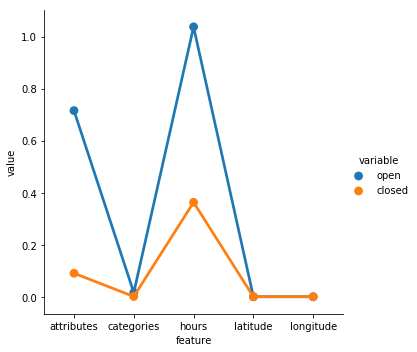

In [21]:
nulls_count = pd.DataFrame({"open":(b[b.is_open == True].isnull().sum()/len(b[b.is_open == False])).round(5), 
                           "closed":(b[b.is_open == False].isnull().sum()/len(b[b.is_open == False])).round(5)})

nulls_count = nulls_count[(nulls_count.open > 0) | (nulls_count.closed > 0)]
nulls_count["feature"] = nulls_count.index
nulls_count_melted = pd.melt(nulls_count, id_vars=['feature'], value_vars=['open', 'closed'])
sns.catplot(x="feature", y="value", hue="variable", kind="point", data=nulls_count_melted)
sns.despine()
plt.show()

No, closed business have much lesser nulls

#### Class imbalance

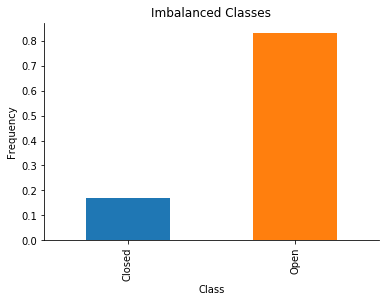

In [22]:
count_classes = pd.value_counts(b.is_open, sort=True, normalize=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

* 23% of hours is missing. I can drop hours

* 0.29 % rows have missing category. I can drop those rows

* 0.001 % rows have missing latitude, longitude information. Dropping them will not affect the data

* I am not going to use the attributes feature. 

In [23]:
b.drop("hours", axis=1, inplace=True)
b = b.drop(b[b.categories.isnull()].index)
b = b.drop(b[(b.latitude.isnull()) | (b.longitude.isnull()) ].index)
b = b.drop("attributes", axis=1)
# nulls in percent
((b.isnull().sum()/len(b)) * 100).round(5)

address         0.0
business_id     0.0
categories      0.0
city            0.0
is_open         0.0
latitude        0.0
longitude       0.0
name            0.0
neighborhood    0.0
postal_code     0.0
review_count    0.0
stars           0.0
state           0.0
dtype: float64

### Binarize Categories

A business is labeled to more than one categories. Converting them to binary will make filtering and analyzing very easy. Let me try to one-hot encode them.  

In [24]:
b.categories.head()

0    Tours, Breweries, Pizza, Restaurants, Food, Ho...
1    Chicken Wings, Burgers, Caterers, Street Vendo...
2    Breakfast & Brunch, Restaurants, French, Sandw...
3                        Insurance, Financial Services
4    Home & Garden, Nurseries & Gardening, Shopping...
Name: categories, dtype: object

Splitting by comma works except for businesses that have a single category seprated by commas. 

- Books, Mags, Music & Video
- Used, Vintage & Consignment
- Beer, Wine & Spirits
- Wills, Trusts, & Probates

Since there is no syntatical difference beween single category containing comma and multiple categories separated by comma, i couln't find a regex expression to deal with this problem. Replacing manually is the remaining option.

In [25]:
b.loc[:, 'categories'] = b.categories.str.replace("Books, Mags, Music & Video", "Books+Mags+ & MusicVideo")
b.loc[:, 'categories'] = b.categories.str.replace("Used, Vintage & Consignment", "Used+Vintage+ & Consignment")
b.loc[:, 'categories'] = b.categories.str.replace("Beer, Wine & Spirits", "Beer+Wine & Spirits")
b.loc[:, 'categories'] = b.categories.str.replace("Wills, Trusts, & Probates", "Wills+Trusts+&Probates")

One hot encoding is for single label categorical variables. For multiple labels Scikit-learn's MultiLabelBinarizer is the way to go. 

In [26]:
# split by comma
categories_series = b.categories.apply(lambda x: x.split(","))
# a  lambda function to convert the following data structure
# [list(['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel'])
# to 
# ['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel']
take_out_list = lambda x: list(x)
# get 2D list
categories_2D_list = take_out_list(categories_series)
# remove leading and trailing white spaces
for alist in categories_2D_list:
    alist[:] = [category.strip() for category in alist]
#print(categories_2D_list[:3])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_binarized = mlb.fit_transform(categories_2D_list)
#print(categories_binarized.shape)
#print(mlb.classes_.shape)
# mlb.classes_ returns the unique categories found by the binarizer
categories_binarized_df = pd.DataFrame(categories_binarized, columns=list(mlb.classes_))
categories_binarized_df.sample(10)

,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Acupuncture,Addiction Medicine,Adoption Services,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
40427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68854,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
mlb.classes_

array(['3D Printing', 'ATV Rentals/Tours', 'Acai Bowls', ..., 'Yoga',
       'Ziplining', 'Zoos'], dtype=object)

#### Top 20 Business Categories

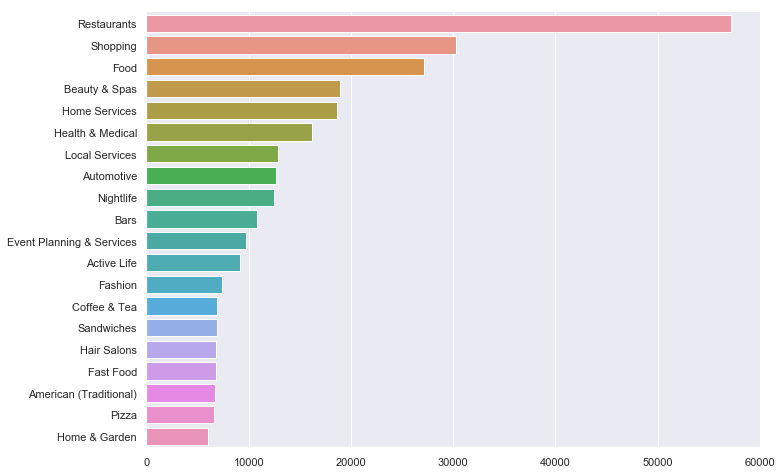

In [28]:
top_20_categories = categories_binarized_df.sum().sort_values(ascending=False)[:20]
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(y=top_20_categories.index, x=top_20_categories.values, orient='h')
sns.despine()

**Are these categories combined in groups of 3 or more?**

In [29]:
# find the number of total busineses
total_business = categories_binarized_df.shape[0]

combinations_of_top20 = categories_binarized_df[top_20_categories.index].apply(lambda x: list(x.index[np.where(x != 0)]), axis=1)

value_counts_top20 = combinations_of_top20.value_counts()

# convert index to string to make it hashable
import json
# dumps converts list to string
value_counts_top20.index = value_counts_top20.index.map(json.dumps)
count_g_2 = 0
for c in value_counts_top20.index:
    # count combinations of two or more categories
    # loads converts back to list
    if(len(json.loads(c)) > 2):
        count_g_2 += value_counts_top20.loc[c]
print(count_g_2)
print(np.round((count_g_2/total_business) * 100, 2), "%")

26718
14.21 %


Only 14% of all businesses have combined categories from the top-20 categories

In [30]:
total_business

188045

#### Closure rate in the top categories

In [31]:
top_20_categories.index

Index(['Restaurants', 'Shopping', 'Food', 'Beauty & Spas', 'Home Services',
       'Health & Medical', 'Local Services', 'Automotive', 'Nightlife', 'Bars',
       'Event Planning & Services', 'Active Life', 'Fashion', 'Coffee & Tea',
       'Sandwiches', 'Hair Salons', 'Fast Food', 'American (Traditional)',
       'Pizza', 'Home & Garden'],
      dtype='object')

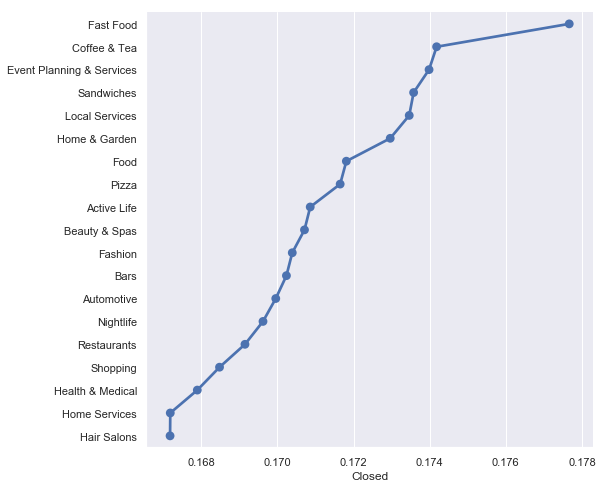

In [32]:
# concatenate is_open info to the binaried categories data
open_close_df = pd.concat([categories_binarized_df[top_20_categories.index], b.is_open], axis=1)
# find all open businesses
open_df = open_close_df[open_close_df.is_open ==1]
# find all closed businesses
close_df = open_close_df[open_close_df.is_open ==0]
# sum across columns to find number of open business in each column(category)
open_close_count = (pd.concat([open_df.sum(), close_df.sum()], axis=1))
# change the default column names
open_close_count.columns = ["Open", "Closed"]
#print(open_close_count)
# divide the counts by the total businesses in each category
open_close_count_normalized = open_close_count.div(open_df.sum() + close_df.sum(), axis=0).sort_values(by="Closed", ascending=False)[:-2]
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.pointplot(x=open_close_count_normalized.Closed, y=open_close_count_normalized.index, orient='h')
sns.despine()

Those businesses that are at the end of the top 20 list are on the top on this graph and vice versa. Fast-food and Coffee/Tea have the highest closure rate though they are limited in number compared to the other businesses. Shopping centers and Health and Medical businesses are in large quantities but they are least likely to be closed.

#### Number of Reviews: Restaurants vs Shopping

In [33]:
categories_binarized_df["business_id"] = b.business_id.values
categories_binarized_df["is_open"] = b.is_open.values

restaurants_df =  categories_binarized_df[categories_binarized_df.Restaurants == 1]
shopping_df = categories_binarized_df[categories_binarized_df.Shopping == 1]

total_reviews = 5996996

# # the code below takes time. The results are saved to file and loaded in the next cell

# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# num_restaurant_reviews = 0
# num_shopping_reviews = 0
# total_reviews = 0 
# for i, r in enumerate(review_reader):
#     total_reviews += r.shape[0]
#     print("working on chunk ",i," shape =", r.shape[0])
#     # count number of restaurant reviews found in chunk r
#     num_restaurant_reviews += pd.merge(restaurants_df, r, on=["business_id"]).shape[0]
#     # count number of shopping reviews found in chunk r
#     num_shopping_reviews += pd.merge(shopping_df, r, on=["business_id"]).shape[0]

# pickle.dump(num_restaurant_reviews, open("../../../../../yelp-dataset/num_restaurant_reviews.sav", 'wb'))
# pickle.dump(num_shopping_reviews,open("../../../../../yelp-dataset/num_shopping_reviews.sav", 'wb'))

In [34]:
num_restaurant_reviews = pickle.load(open("../../../../../yelp-dataset/num_restaurant_reviews.sav", 'rb'))
num_shopping_reviews = pickle.load(open("../../../../../yelp-dataset/num_shopping_reviews.sav", 'rb'))

print("Percent of Restaurant Businesses: {:.2f}".format(restaurants_df.shape[0] / total_business))
print("Percent of Shopping Businesses: {:.2f}".format(shopping_df.shape[0] / total_business))
print()
print("Percent of Restaurant Reviews: {:.2f}".format(num_restaurant_reviews / total_reviews))
print("Percent of Shopping Reviews: {:.2f}".format(num_shopping_reviews / total_reviews))

Percent of Restaurant Businesses: 0.30
Percent of Shopping Businesses: 0.16

Percent of Restaurant Reviews: 0.30
Percent of Shopping Reviews: 0.16


There are as much restaurant reviews as the number of restaurant businesses. The same for shopping businesses and reviews. I think Yelp people used stratified sampling technique to include reviews according to the proportion of a business type.

### Reviews by Year

In [35]:
# The following code takes 15 minutes. Saved data is loaded in the next cell


# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# total_reviews = 0 
# restaurant_open_review_years = []
# restaurant_closed_review_years = []
# shopping_open_review_years = []
# shopping_closed_review_years = []

# for i, r in enumerate(review_reader):
#     total_reviews += r.shape[0]
#     print("working on chunk ",i," shape =", r.shape[0])
    
#     restaurant_reviewsR = pd.merge(restaurants_df, r, on=["business_id"])
    
#     restaurant_reviews_closed = restaurant_reviewsR[restaurant_reviewsR.is_open == 0]
#     restaurant_reviews_open = restaurant_reviewsR[restaurant_reviewsR.is_open == 1]
    
    
#     restaurant_closed_review_years.append(pd.to_datetime(restaurant_reviews_closed.date.dt.year).values)
#     restaurant_open_review_years.append(pd.to_datetime(restaurant_reviews_open.date.dt.year).values)
 
#     shopping_restaurantR= pd.merge(shopping_df, r, on=["business_id"])
    
#     shopping_reviews_closed = shopping_restaurantR[shopping_restaurantR.is_open == 0]
#     shopping_reviews_open = shopping_restaurantR[shopping_restaurantR.is_open == 1]
    
#     shopping_closed_review_years.append(pd.to_datetime(shopping_reviews_closed.date.dt.year).values)
#     shopping_open_review_years.append(pd.to_datetime(shopping_reviews_open.date.dt.year).values)
    
# # save the lists to file
# pickle.dump(restaurant_open_review_years, open("../../../../../yelp-dataset/restaurant_open_review_years.sav", 'wb'))
# pickle.dump(restaurant_closed_review_years, open("../../../../../yelp-dataset/restaurant_closed_review_years.sav", 'wb'))
# pickle.dump(shopping_open_review_years, open("../../../../../yelp-dataset/shopping_open_review_years.sav",'wb'))
# pickle.dump(shopping_closed_review_years, open("../../../../../yelp-dataset/shopping_closed_review_years.sav", 'wb'))

In [36]:
# load lists from file
restaurant_open_review_years = pickle.load(open("../../../../../yelp-dataset/restaurant_open_review_years.sav", 'rb'))
restaurant_closed_review_years = pickle.load(open("../../../../../yelp-dataset/restaurant_closed_review_years.sav", 'rb'))
shopping_open_review_years = pickle.load(open("../../../../../yelp-dataset/shopping_open_review_years.sav", 'rb'))
shopping_closed_review_years = pickle.load(open("../../../../../yelp-dataset/shopping_closed_review_years.sav", 'rb'))

restaurant_open_review_years = np.concatenate(restaurant_open_review_years).ravel()
restaurant_closed_review_years = np.concatenate(restaurant_closed_review_years).ravel()
shopping_open_review_years = np.concatenate(shopping_open_review_years).ravel()
shopping_closed_review_years = np.concatenate(shopping_closed_review_years).ravel()

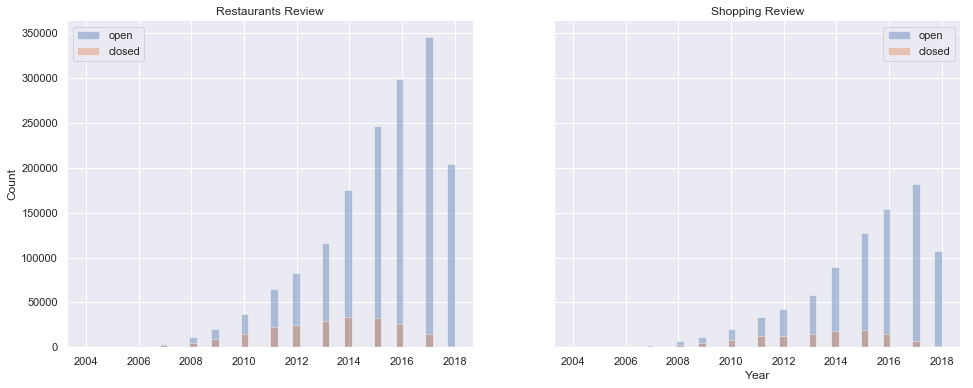

In [176]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6), sharey=True)

sns.set(rc={'figure.figsize':(4,4)})
sns.distplot(restaurant_open_review_years.astype(int), kde=False, label="open", ax=ax1)
sns.distplot(restaurant_closed_review_years.astype(int), kde=False, label = "closed", ax=ax1)
ax1.legend()
ax1.set_ylabel("Count")
ax2.set_xlabel("Year")
ax1.set_title("Restaurants Review")

sns.distplot(shopping_open_review_years.astype(int), kde=False, label="open", ax=ax2)
sns.distplot(shopping_closed_review_years.astype(int), kde=False, label = "closed", ax=ax2)
ax2.set_title("Shopping Review")
ax2.set_xlabel("Year")
ax1.set_ylabel("Count")
sns.despine()
ax2.legend()
plt.show()

The information on when a restaurant is closed is not provided by Yelp. We can only approximate the rate of closure based on the distrubiton of reviews. The graph shows that restaurants started recieving reviews on Yelp since 2004 and the reviews continued to increase. 2017 is the peak year for open restaurants. Many restaurants that were reviewed in 2014 are closed. We can not be sure whether they were closed in the same year or later.

Many shopping businesses that were reviewed in 2014-15 are closed by now.

### Approxmating Restaurants Age

In [38]:
#The following code takes 15 minutes. Saved data is loaded in the next cell

# csize = 1e6
# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# total_reviews = 0 
# #restaurant_open_last_review_year = []
# #hopping_open_last_review_year = 
# #hopping_closed_last_review_year = []
# for i, r in enumerate(review_reader):
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         print("working on chunk ",i," shape =", r.shape[0])

#         restaurant_reviewsR = pd.merge(restaurants_df, r, on=["business_id"])

#         restaurant_reviewsR["review_year"] = pd.to_datetime(restaurant_reviewsR.date.dt.year)

#         if(i == 0):
#             restaurants_open_year = restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].min()
#             restaurants_closed_year = restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].max()

#         else:
#             restaurants_open_year = pd.concat([restaurants_open_year, restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].min()])
#             restaurants_closed_year = pd.concat([restaurants_closed_year, restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].max()])

# # save the dataframes to file
# pickle.dump(restaurants_open_year, open("../../../../../yelp-dataset/restaurants_open_year.sav", 'wb'))
# pickle.dump(restaurants_closed_year, open("../../../../../yelp-dataset/restaurants_closed_year.sav", 'wb'))

In [39]:
# open and close in the file names refer to earliest review year and most recent review years
# it is a naming mistake made when dumping the objects
earliest_review_year_all = pickle.load(open("../../../../../yelp-dataset/restaurants_open_year.sav", 'rb'))
most_recent_review_year_all = pickle.load(open("../../../../../yelp-dataset/restaurants_closed_year.sav", 'rb'))

earliest_review_year = earliest_review_year_all.groupby("business_id").min()
most_recent_review_year = most_recent_review_year_all.groupby("business_id").max()

restaurants_dates = pd.concat([earliest_review_year, most_recent_review_year], axis=1)
restaurants_dates.columns = ["earliest_review_year", "most_recent_review_year"]
# filter required attributes
restaurants_only = pd.merge(b[["business_id", "latitude", "longitude", "stars","review_count", "is_open"]], 
                            restaurants_dates, on="business_id")
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,is_open,earliest_review_year,most_recent_review_year
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,1,1970-01-01 00:00:00.000002013,1970-01-01 00:00:00.000002018
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,0,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000002017
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,0,1970-01-01 00:00:00.000002014,1970-01-01 00:00:00.000002016
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,1,1970-01-01 00:00:00.000002012,1970-01-01 00:00:00.000002014
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,1,1970-01-01 00:00:00.000002008,1970-01-01 00:00:00.000002018


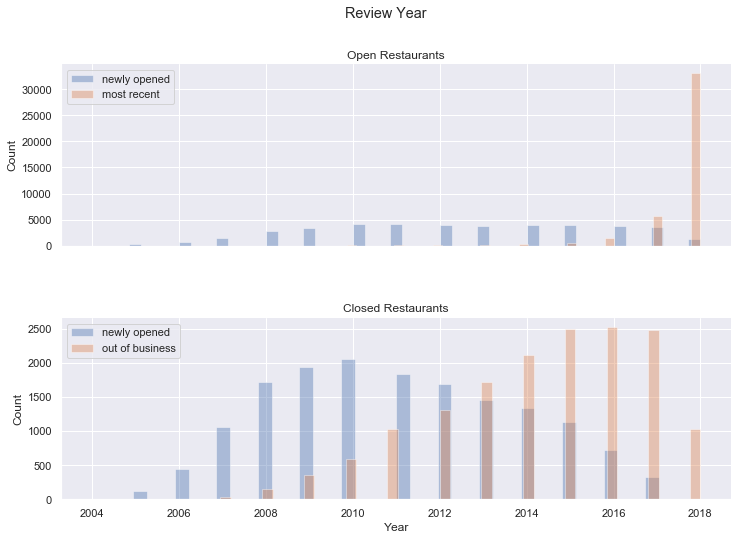

In [40]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

sns.set(rc={'figure.figsize':(4,4)})

open_earliest_years = restaurants_only[restaurants_only.is_open == True].earliest_review_year.values.astype(int)
open_most_recent_years = restaurants_only[restaurants_only.is_open == True].most_recent_review_year.values.astype(int)
closed_earliest_years = restaurants_only[restaurants_only.is_open == False].earliest_review_year.values.astype(int)
closed_most_recent_years = restaurants_only[restaurants_only.is_open == False].most_recent_review_year.values.astype(int)


sns.distplot(open_earliest_years, kde=False, label="newly opened", ax=ax1)
sns.distplot(open_most_recent_years, kde=False, label = "most recent", ax=ax1)

sns.distplot(closed_earliest_years, kde=False, label="newly opened", ax=ax2)
sns.distplot(closed_most_recent_years, kde=False, label = "out of business", ax=ax2)

ax1.set_title("Open Restaurants")
ax2.set_title("Closed Restaurants")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")

ax2.set_xlabel("Year")
plt.suptitle("Review Year")
sns.despine()

We are approximating the earliest year as the opening year of a restaurant. For currently closed restaurants, the most recent year is approximated as the out of business year.

Looking at the upper graph; almost all currently open restaurants were reviewed within the last 2 years. The distriubtion of earliest review year is left skewed. Since 2010 similar number of restaurants were opened

Looking at the bottom graph; number of newly opened restaurants is normally distributed for closed restaurants. Many restaurants that were opened in 2010 are closed by now. Restaurants that are recently opened are not closed by now. This indicates that new restaurants are not very likely to be closed and it takes some years. The difference betwen number new restaurants(red) and closed restaurants(blue) kept on increasing until 2013 and then it decreases.

They are many contributing factors that are outside the scope of this analysis.

In [41]:
len(set(restaurants_only.business_id))

57173

#### Create Age Feature

In [42]:
restaurants_only["age"] = 2018 - restaurants_only.earliest_review_year.values.astype(int)
restaurants_only = restaurants_only[['business_id', 'latitude', 'longitude', 'stars', 'review_count','age', 'is_open']]
restaurants_only.age.describe()

count    57173.000000
mean         5.993266
std          3.145764
min          0.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         14.000000
Name: age, dtype: float64

#### Class Imbalance

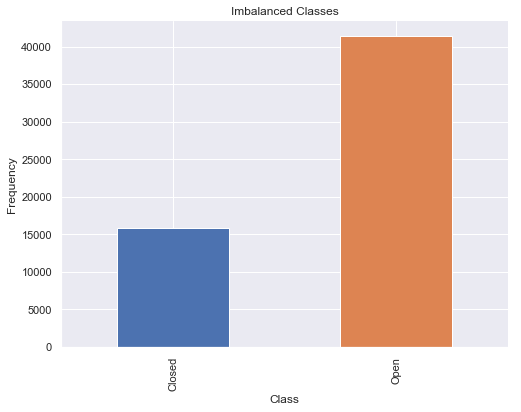

In [43]:
sns.set(rc={'figure.figsize':(8,6)})
count_classes = pd.value_counts(restaurants_only.is_open, sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

In [44]:
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,age,is_open
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,5,1
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,1,0
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,4,0
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,6,1
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,10,1


### Outliers

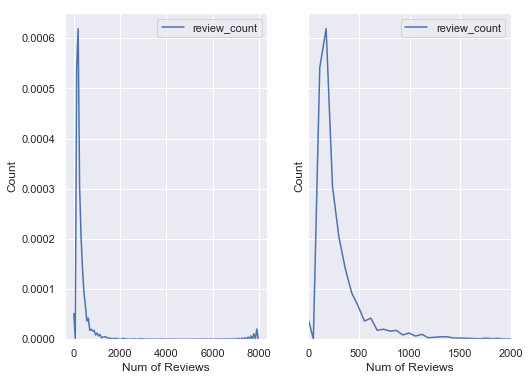

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6), sharey=True)
# making spaces between subplots
#fig.subplots_adjust(hspace = 0.2, wspace = 0.2)
ax1.set_xlabel("Num of Reviews")
ax2.set_xlabel("Num of Reviews")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")
sns.kdeplot(restaurants_only.review_count.sort_values(), ax=ax1)
sns.kdeplot(restaurants_only.review_count.sort_values(), ax=ax2)
ax2.set_xlim(0, 2000)
plt.show()

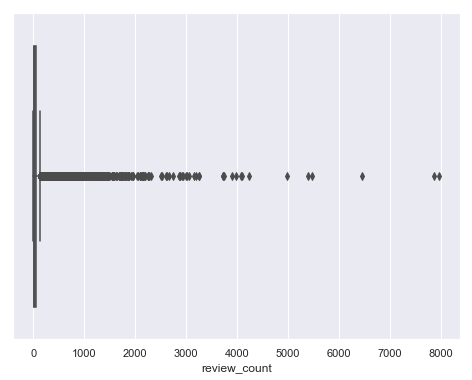

In [46]:
sns.boxplot(restaurants_only.review_count.sort_values())
plt.show()

In [47]:
from scipy import stats
z = np.abs(stats.zscore(restaurants_only.review_count))
threshold = 3
outlier_businesses = list(np.where(z > 3)[0])
print("train_size: ", restaurants_only.shape[0])
print("Number of outliers: ", len(outlier_businesses))

train_size:  57173
Number of outliers:  786


In [48]:
business_ids = restaurants_only.iloc[outlier_businesses, 0].to_frame()
pd.merge(business_ids, b, on=["business_id"])[["name", "state", "review_count", "address"]].sample(10)

,name,state,review_count,address
8,Miller's Ale House - Las Vegas,NV,583,6683 Las Vegas Blvd S
309,Hiro Sushi,AZ,622,"9393 N 90th St, Ste 116"
22,La Belle Terre French Bakery And CafÃ©,NV,568,"8390 W Sahara Ave, Ste 130"
407,Cibo,AZ,1866,603 N 5th Ave
58,Bouchon Bakery at the Venetian Theater,NV,1115,"3355 Las Vegas Blvd S, Venetian Theater, Sport..."
738,Planet Dailies,NV,621,3667 Las Vegas Blvd S
56,Thai Style Noodle House,NV,696,3516 Wynn Rd
405,Mert's Heart & Soul,NC,840,214 N College St
300,Backyard Taco,AZ,1082,1524 E University
711,Rose. Rabbit. Lie.,NV,841,"3708 Las Vegas Blvd S, Level 2, The Chelsea Tower"


In [49]:
restaurants_only.shape

(57173, 7)

In [50]:
restaurants_only = restaurants_only.drop(outlier_businesses)

In [51]:
restaurants_only.shape

(56387, 7)

### Bag of Words

In [52]:
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,age,is_open
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,5,1
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,1,0
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,4,0
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,6,1
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,10,1


In [53]:
# tokenizer pattern and replace practice
# myvect = CountVectorizer(stop_words = 'english')
# somelist = pd.Series(["Tinse is great ጥሩ ˈdäNG person", "Ethiopia is my country!", "15Brown fox", "Quick", "13 it is nice"])
# somelist = somelist.str.replace(r'(?u)[^\w\s]+|[\d]+', '')
# print(somelist)
# myvect.fit_transform(somelist)
# print(myvect.vocabulary_)

In [54]:
# # Takes a lot of time. Saved models are loaded in the next cells
# import time
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# csize=1e6
# start_time = time.time()
# review_reader = pd.read_json("../../../../../yelp-dataset/yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     print("working on chunk ",i," shape =", r.shape[0])
#     restaurants_reviews = pd.merge(restaurants_only, r, on=["business_id"])
#     # save dense matrix to file
#     restaurants_reviews.to_csv("../../../../../yelp-dataset/restaurants_reviews"+ str(i) + ".csv")
#     # tokens containing numbers, digits and underscore are ignored

#     restaurants_vectorizer = CountVectorizer(stop_words='english', min_df=0.001) 
#     # remove punctuation and numbers
#     restaurants_reviews.text = restaurants_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
#     restaurants_bow_features = restaurants_vectorizer.fit_transform(restaurants_reviews.text)
#     # save vectorizer
#     pickle.dump(restaurants_vectorizer, open("../../../../../yelp-dataset/restaurants_vectorizer"+ str(i) +".sav", 'wb'))
#     # save sparse matrix to file
#     sparse.save_npz("../../../../../yelp-dataset/restaurants_bow_features"+ str(i) + ".npz", restaurants_bow_features)
#     print("shape of dense matrix: ", restaurants_reviews.shape)
#     print("shape of sparse matrix: ", restaurants_bow_features.shape)
# print(time.time() - start_time)

#### Number of Businesses in the Chunks

In [55]:
from scipy import sparse
import pickle
import operator

for i in range(6):
    #sparse = sparse.load_npz("../../../../../yelp-dataset/restaurants_bow_features" + i + ".npz")
    #vectorizer = pickle.load(open("../../../../../yelp-dataset/restaurants_vectorizer"+ i + ".sav", 'rb'))
    restaurants_reviews = pd.read_csv("../../../../../yelp-dataset/restaurants_reviews" + str(i) + ".csv", index_col=0)
    #word_headers = np.array(sorted(restaurants_vectorizer.vocabulary_.items(), key=operator.itemgetter(1)))[:,0]
    num_of_businesses = len(restaurants_reviews.business_id.groupby(restaurants_reviews.business_id).groups.items())
    #num_of_businesses = len(set(dense.business_id))
    print("chunk ", i, " number of businesses: ", num_of_businesses)

chunk  0  number of businesses:  47675
chunk  1  number of businesses:  47794
chunk  2  number of businesses:  47490
chunk  3  number of businesses:  47316
chunk  4  number of businesses:  47105
chunk  5  number of businesses:  47651


The numbers are very close to each other. We can use one of the chunks.

#### Using Chunk 2 as a sample

In [56]:
i = 2
restaurants_bow_features = sparse.load_npz("../../../../../yelp-dataset/restaurants_bow_features" + str(i) + ".npz")
restaurants_vectorizer = pickle.load(open("../../../../../yelp-dataset/restaurants_vectorizer"+ str(i) + ".sav", 'rb'))
restaurants_reviews = pd.read_csv("../../../../../yelp-dataset/restaurants_reviews" + str(i) + ".csv", index_col=0)
# these are the >3000 word features in the sparse matrix order(alphabetical)
bow_features_names = restaurants_vectorizer.get_feature_names()[:10]
# get the indices of reviews for each business id
reviews_indices_dict = restaurants_reviews.business_id.groupby(restaurants_reviews.business_id).groups
print("Showing 6 businesses from ", len(reviews_indices_dict.keys()))
for i, item in enumerate(reviews_indices_dict.items()):
    if(i > 5):
        break;
    print(item)
print(restaurants_bow_features.shape)
print(restaurants_reviews.shape)

Showing 6 businesses from  47490
('--1UhMGODdWsrMastO9DZw', Int64Index([272207, 272208], dtype='int64'))
('--6MefnULPED_I942VcFNA', Int64Index([105260, 105261, 105262, 105263, 105264, 105265, 105266, 105267], dtype='int64'))
('--DaPTJW3-tB1vP-PfdTEg', Int64Index([140039, 140040, 140041, 140042, 140043, 140044, 140045, 140046], dtype='int64'))
('--FBCX-N37CMYDfs790Bnw', Int64Index([442444, 442445, 442446, 442447, 442448, 442449, 442450, 442451,
            442452, 442453, 442454, 442455, 442456, 442457, 442458, 442459,
            442460, 442461, 442462, 442463, 442464, 442465, 442466],
           dtype='int64'))
('--GM_ORV2cYS-h38DSaCLw', Int64Index([249795, 249796], dtype='int64'))
('--I7YYLada0tSLkORTHb5Q', Int64Index([67055, 67056, 67057, 67058, 67059, 67060, 67061, 67062, 67063,
            67064, 67065, 67066, 67067, 67068, 67069],
           dtype='int64'))
(476253, 3994)
(476253, 15)


### Word Counts Per Business

In [57]:
len(list(reviews_indices_dict.items()))

47490

In [58]:
# import time
# the_sparse_matrices = []
# #takes 10 minutes
# start_time = time.time()
# restaurants_vectorizer = pickle.load(open("../../../../../yelp-dataset/restaurants_vectorizer2.sav", 'rb'))
# num_of_sparse_features = len(restaurants_vectorizer.vocabulary_)
# # initial coo matrix-all zeros
# #the_matrix = coo_matrix(np.array([0] * num_of_sparse_features ))
# # k goes over the business ids
# # i counts
# for i, k in enumerate(reviews_indices_dict.keys()):
#     if( i % 10000 == 0):
#         print("creating row: ", i)
#     # convert to list: row indices for the reviews of k
#     indices_for_sparse_matrix = list(reviews_indices_dict[k])
#     #print(indices_for_sparse_matrix)
#     #print(k)
#     # find means column-wise
#     means_sparse = restaurants_bow_features[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
#     the_sparse_matrices.append(means_sparse)
# print(time.time() - start_time)
# # save aggregate sparse matrix
# pickle.dump(the_sparse_matrices, open("../../../../../yelp-dataset/the_sparse_matrices.sav", "wb"))

In [59]:
the_sparse_matrices = pickle.load(open("../../../../../yelp-dataset/the_sparse_matrices.sav", "rb"))

### Bag of Words + Other Features

In [60]:
restaurants_bow_aggregate = sparse.csr_matrix(the_sparse_matrices)

In [61]:
# calculate sparsity
print("Sparsity: ", restaurants_bow_aggregate.mean())
print("No of businesses", len(reviews_indices_dict.keys()))
print("Shape of the aggregate sparse matrix ", restaurants_bow_aggregate.shape)

Sparsity:  0.010765427090639112
No of businesses 47490
Shape of the aggregate sparse matrix  (47490, 3994)


In [62]:
restaurants_reviews.columns

Index(['business_id', 'latitude', 'longitude', 'stars_x', 'review_count',
       'age', 'is_open', 'cool', 'date', 'funny', 'review_id', 'stars_y',
       'text', 'useful', 'user_id'],
      dtype='object')

In [63]:
# select features
restaurants_reviews_n = restaurants_reviews[['business_id', 'stars_x', 'review_count', 'latitude','longitude','age', 'is_open']]
# rename age to age_of_restaurant, stars_x to average_stars
restaurants_reviews_n.columns = ['business_id', "average_stars", 'review_count','latitude', 'longitude','age_of_restaurant', 'is_open']
# round to 3 precision
#restaurants_reviews = restaurants_reviews.round(3)
# remove duplicates
restaurants_reviews_n.drop_duplicates(inplace=True)
restaurants_reviews_n.shape

C:\Users\Tinsae\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(47490, 7)

In [64]:
restaurants_reviews_n.head()

,business_id,average_stars,review_count,latitude,longitude,age_of_restaurant,is_open
0,Apn5Q_b6Nz61Tq4XzPdf9A,4.0,24,51.091813,-114.031675,5,1
3,6OuOZAok8ikONMS_T3EzXg,2.0,7,43.712946,-79.632763,6,1
4,8-NRKkPY1UiFXW20WXKiXg,2.5,40,33.448106,-112.341302,10,1
12,tZnSodhPwNr4bzrwJ1CSbw,4.0,146,43.664125,-79.411886,10,0
35,_c3ixq9jYKxhLUB0czi0ug,4.0,277,33.479807,-112.091188,12,1


The order of businesses in restaurants_reviews is arbitrary. But the sparse matrix used ordered business ids.

In [65]:
# are the business ids ordered
business_ids_of_agg_sparse =  list(reviews_indices_dict.keys())
print(all(business_ids_of_agg_sparse[i] <= business_ids_of_agg_sparse[i+1] for i in range(len(business_ids_of_agg_sparse)-1)))

True


The order in the sparse matrix can be matched just by sorting the business_ids in ascending order

In [66]:
# sort, reindex
restaurants_reviews_n = restaurants_reviews_n.sort_values(by = "business_id").reset_index(drop=True)
restaurants_reviews_n.head(5)

,business_id,average_stars,review_count,latitude,longitude,age_of_restaurant,is_open
0,--1UhMGODdWsrMastO9DZw,4.0,24,51.049673,-114.079977,2,1
1,--6MefnULPED_I942VcFNA,3.0,39,43.840905,-79.399604,10,1
2,--DaPTJW3-tB1vP-PfdTEg,3.5,45,43.677807,-79.444674,6,1
3,--FBCX-N37CMYDfs790Bnw,4.0,125,35.978679,-115.155057,9,1
4,--GM_ORV2cYS-h38DSaCLw,4.0,8,40.252503,-80.183900,5,1


In [67]:
# drop business id
restaurants_reviews_n = restaurants_reviews_n.drop('business_id', axis=1)
# rearrange columns
restaurants_reviews_n = restaurants_reviews_n[["is_open", "average_stars", "review_count", "latitude", "longitude","age_of_restaurant"]]

In [68]:
restaurants_reviews_n.head()

,is_open,average_stars,review_count,latitude,longitude,age_of_restaurant
0,1,4.0,24,51.049673,-114.079977,2
1,1,3.0,39,43.840905,-79.399604,10
2,1,3.5,45,43.677807,-79.444674,6
3,1,4.0,125,35.978679,-115.155057,9
4,1,4.0,8,40.252503,-80.183900,5


In [69]:
restaurants_bow_aggregate

<47490x3994 sparse matrix of type '<class 'numpy.float64'>'
	with 10593362 stored elements in Compressed Sparse Row format>

In [70]:
restaurants_reviews_n.shape

(47490, 6)

In [71]:
restaurants_final_data = hstack((restaurants_reviews_n,restaurants_bow_aggregate)).tocsr()

### Train/Test Split

In [72]:
X = restaurants_final_data[:, 1:]

# # change is_open to is_closed
y = np.where(restaurants_final_data[:,0].toarray() == 0 , 1, 0)

# # stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True, stratify=y)

In [73]:
X_train[:5].toarray()

array([[  3.5       , 318.        ,  33.6834609 , ...,   0.        ,
          0.        ,   0.        ],
       [  2.5       ,  43.        ,  33.4935632 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.5       ,  51.        ,  35.21244   , ...,   0.        ,
          0.        ,   0.        ],
       [  1.5       ,   6.        ,  40.02830515, ...,   0.        ,
          0.        ,   0.        ],
       [  4.        , 462.        ,  43.07243   , ...,   0.        ,
          0.        ,   0.        ]])

In [74]:
X_test[:5].toarray()

array([[ 1.5      ,  9.       , 43.0956809, ...,  0.       ,  0.       ,
         0.       ],
       [ 3.       , 30.       , 33.4657151, ...,  0.       ,  0.       ,
         0.       ],
       [ 4.       , 12.       , 43.64522  , ...,  0.       ,  0.       ,
         0.       ],
       [ 4.5      ,  8.       , 45.496425 , ...,  0.       ,  0.       ,
         0.       ],
       [ 3.5      ,  6.       , 36.131979 , ...,  0.       ,  0.       ,
         0.       ]])

### Distance Features
Within 1 mile circle, average ratings, average number of reviews

In [75]:
print("min latitude", X_train[:,2].min())
print("max latitude", X_train[:,2].max())
print("min longtiude", X_train[:,3].min())
print("max longtiude", X_train[:,3].max())

min latitude -34.8693315397
max latitude 59.438181380799996
min longtiude -123.5874264
max longtiude 115.08676899999999


In [76]:
X_train_sep = pd.DataFrame({'average_stars':X_train[:,0].toarray().flatten(),
                            'review_count':X_train[:,1].toarray().flatten(),
                            'latitude':X_train[:,2].toarray().flatten(),
                            'longitude':X_train[:,3].toarray().flatten()})


X_train_sep.head()

,average_stars,review_count,latitude,longitude
0,3.5,318.0,33.683461,-111.965779
1,2.5,43.0,33.493563,-111.922724
2,3.5,51.0,35.212440,-80.835393
3,1.5,6.0,40.028305,-88.578334
4,4.0,462.0,43.072430,-89.384340


In [77]:
X_train_sep.shape

(37992, 4)

In [78]:
# A vectorized implemenation of geopy.distance.great_circle function
# Adopted by Tinsae 
# reference
# https://gist.github.com/rochacbruno/2883505
    
import math
# calculate the disance between a business and all other businesses
def distance_c(many_points, one_point):
    # convert the values to float
    lat1 = many_points[:,0].astype(float) 
    lon1 = many_points[:,1].astype(float)
    lat2 = one_point[0]
    lon2 = one_point[1]
    #radius = 6371 # km
    radius = 3959 # miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

# for testing purposes(calculating the distance between buisness@1 and others)
business5 = X_train_sep[['latitude', 'longitude']].values[5:6]
business8 = X_train_sep[['latitude', 'longitude']].values[8:9]
business18 = X_train_sep[['latitude', 'longitude']].values[18:19]
business1 = X_train_sep[['latitude', 'longitude']].values[1]

print("distance from 5: ", great_circle(business5, business1).miles)
print("distance from 8: ", great_circle(business8, business1).miles)
print("distance from 18: ", great_circle(business18, business1).miles)

distance_c(X_train_sep[['latitude', 'longitude']].values[0:20], business1)       

distance from 5:  1879.7699797006924
distance from 8:  1875.706764718995
distance from 18:  259.56745678916485


array([  13.35345434,    0.        , 1770.15646495, 1364.05684364,
       1383.84160073, 1879.88324844,   13.38799749,  263.09685355,
       1875.81978863, 1877.01480846,  261.99572402, 1804.81896118,
       1818.37045069,    8.47603207, 1877.49469178,  266.29323998,
       1758.69643561, 1218.03040445,  259.58309747, 1734.28812112])

The results match with little precision loss

### Distance Tranformer

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

class DistanceFeaturesCreator(BaseEstimator, TransformerMixin):
    def transform(self, X, *_):
        self.nearest_average_rating=[]
        self.nearest_average_num_of_reviews =[]

        self.X = X
        self.X_sep = pd.DataFrame({'average_stars':X[:,0].toarray().flatten(),
                            'review_count':X[:,1].toarray().flatten(),
                            'latitude':X[:,2].toarray().flatten(),
                            'longitude':X[:,3].toarray().flatten()})
        
        self.X_sep.apply(lambda current: self.create_distance_features(current), axis=1)
        nearest_average_rating = np.array(self.nearest_average_rating).reshape(-1,1)
        nearest_average_num_of_reviews = np.array(self.nearest_average_num_of_reviews).reshape(-1,1)

        return sparse.hstack((nearest_average_rating, nearest_average_num_of_reviews, self.X.astype(float)))
    
    # calculate the disance between a business and all other businesses
    def distance_c(self, many_points, one_point):
        # convert the values to float
        lat1 = many_points[:,0].astype(float) 
        lon1 = many_points[:,1].astype(float)
        lat2 = one_point[0]
        lon2 = one_point[1]
        #radius = 6371 # km
        radius = 3959 # miles
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
            * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = radius * c
        return d        
    
    def create_distance_features(self, current):
        # find the distance between current row and all other rows using the vectorized function
        the_distances = self.distance_c(self.X_sep[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
        # A distance cannot be negative. 0 indicates it is the same place
        # so both shall be excluded
        indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
        # if a business within one mile is found
        if(len(indices_to_select) > 0):
            self.nearest_average_rating.append(self.X_sep.iloc[indices_to_select, :].average_stars.mean())
            self.nearest_average_num_of_reviews.append(self.X_sep.iloc[indices_to_select, :].review_count.mean())
        else:
            self.nearest_average_rating.append(np.nan)
            self.nearest_average_num_of_reviews.append(np.nan)    
    
    def fit(self, *_):
        return self

### Custom Normalizer

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer, StandardScaler

class CustomNormalizer(BaseEstimator, TransformerMixin):        

    def transform(self, X, *_):
        self.X = X
        # column 4 and 5 are removed(latitude and longitude)
        return sparse.hstack(( StandardScaler().fit_transform(self.X[:, [0,1,2,3,6]].toarray()),  
                              Normalizer().fit_transform(self.X[:, 7:]) ))
    
    def fit(self, *_):
        return self

In [81]:
# # test code
# sc = StandardScaler()
# sc.fit_transform(X_train[:,2].toarray())
# X_train[0:5, 0:5].toarray()
# X_train_transformed.tocsr()[0:5, 0:5].toarray()
# CNR = CustomNormalizer()
# X_train_transformed = CNR.transform(X_train)
# (X_train_transformed).tocsr()[0:5, 0:5].toarray()

In [82]:
# this is used for testing the tranformer

# DFC = DistanceFeaturesCreator()
# X_train_transformed = DFC.transform(X_train)
# (X_train_transformed).tocsr()[0:5, 0:5].toarray()


# import time

# nearest_average_rating = []
# nearest_average_num_of_reviews =  []
# start_time = time.time()

# X_train_sep2 = X_train_sep.copy(deep=True)

# def create_distance_features(current):
#     # find the distance between current row and all other rows using the vectorized function
#     the_distances = distance_c(X_train_sep2[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
#     # A distance cannot be negative. 0 indicates it is the same place
#     # so both shall be excluded
#     indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
#     # if a business within one mile is found
#     if(len(indices_to_select) > 0):
#         nearest_average_rating.append(X_train_sep2.iloc[indices_to_select, :].average_stars.mean())
#         nearest_average_num_of_reviews.append(X_train_sep2.iloc[indices_to_select, :].review_count.mean())
#     else:
#         nearest_average_rating.append("No-Nearest")
#         nearest_average_num_of_reviews.append("No-Nearest")

        
# X_train_sep2.apply(lambda x: create_distance_features(x), axis=1)
# print(time.time() - start_time, " seconds")


# X_train_sep2["nearest_average_rating"] = nearest_average_rating
# X_train_sep2["nearest_average_num_of_reviews"] = nearest_average_num_of_reviews
# X_train_sep2.head()

In [83]:
# # This is for testing

# X_train_transformed
# RNN = RemoveNoNearest()

# RNN = RemoveNoNearest()
# X_transformed_again, y_transformed = RNN.transform(X_train_transformed.tocsr(), y_train)

# X_transformed_again = RNN.transform(X_train_transformed.tocsr())
# X_train_transformed
# X_transformed_again
# X_train_transformed.tocsr()[312, 0:2].toarray()
# np.isnan(X_transformed_again.toarray()).sum()

In [84]:
# from sklearn.preprocessing import StandardScaler
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     scaler = StandardScaler()
#     dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")] = scaler.fit_transform(dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")])
# dense_train_sel_sorted.head(5)

### Construct Pipeline

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer


In [86]:
pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
X_train_t = pipeline.fit_transform(X_train)
X_train_t

<37992x3999 sparse matrix of type '<class 'numpy.float64'>'
	with 8646985 stored elements in COOrdinate format>

In [87]:
# transform X_test
X_test_t = pipeline.transform(X_test)

X_test_t

<9498x3999 sparse matrix of type '<class 'numpy.float64'>'
	with 2183459 stored elements in COOrdinate format>

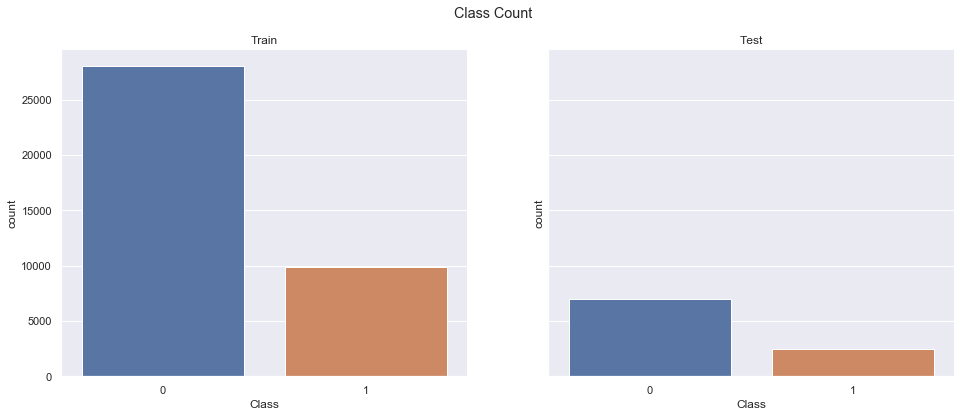

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6), sharey=True)
plt.suptitle("Class Count")
sns.countplot(y_train.flatten(), ax=ax1)
sns.countplot(y_test.flatten(), ax=ax2)
ax1.set_title("Train")
ax2.set_title("Test")
ax1.set_xlabel("Class")
ax2.set_xlabel("Class")
sns.despine()

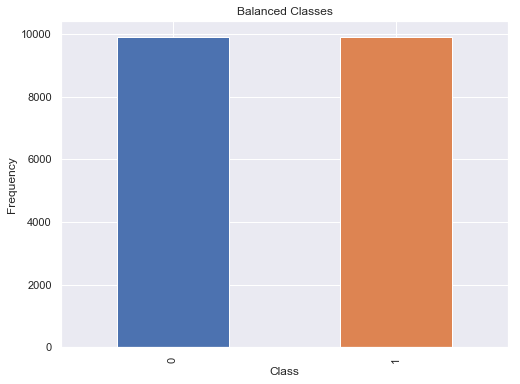

0    9914
1    9914
dtype: int64


In [89]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)
X_test_resampled, y_test_resampled = rus.fit_sample(X_test, y_test)

count_classes = pd.value_counts(y_train_resampled.flatten(), sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Balanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

In [90]:
pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
X_train_rt = pipeline.fit_transform(X_train_resampled)
X_train_rt

<19828x3999 sparse matrix of type '<class 'numpy.float64'>'
	with 4219202 stored elements in COOrdinate format>

In [91]:
pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
X_test_rt = pipeline.fit_transform(X_test_resampled)
X_test_rt

<4958x3999 sparse matrix of type '<class 'numpy.float64'>'
	with 1069226 stored elements in COOrdinate format>

In [92]:
X_train_resampled.shape

(19828, 3999)

In [93]:
X_train_rt.shape

(19828, 3999)

In [94]:
# create dataframe for plotting purpose
column_headers = ['nearest_average_rating', 'nearest_averge_number_of_reviews','average_stars', 
                  'review_count', 'age_of_restaurant']
df = pd.DataFrame(X_train_rt.tocsr()[:, :5 ].toarray(), columns=column_headers)
df.head()

,nearest_average_rating,nearest_averge_number_of_reviews,average_stars,review_count,age_of_restaurant
0,0.446718,0.887342,1.387740,0.620304,-1.721332
1,-0.372693,1.199431,0.727184,3.049227,1.822124
2,0.698089,1.170384,0.066629,2.085578,1.177860
3,1.491159,-0.947131,1.387740,-0.158535,0.211462
4,1.321281,-0.885245,0.727184,0.475097,-0.432802


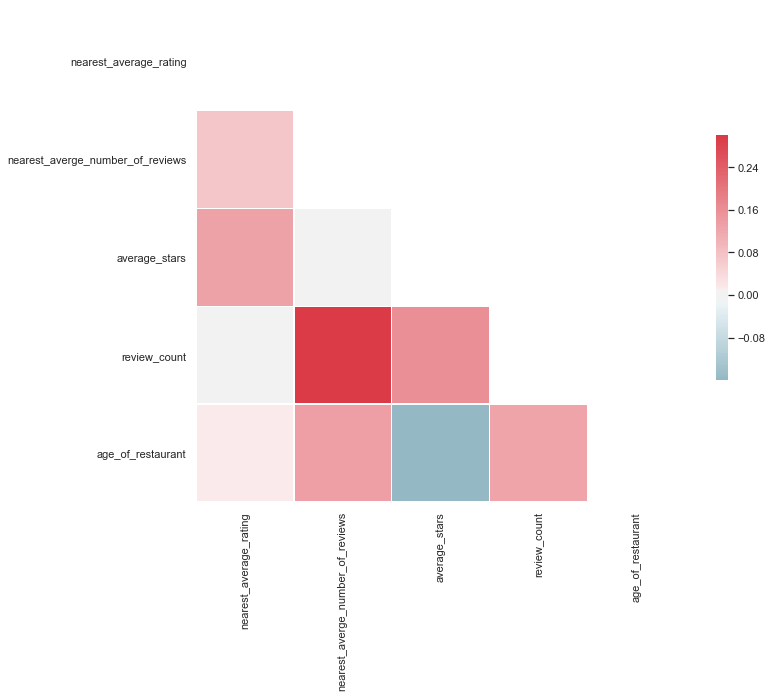

In [178]:

# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

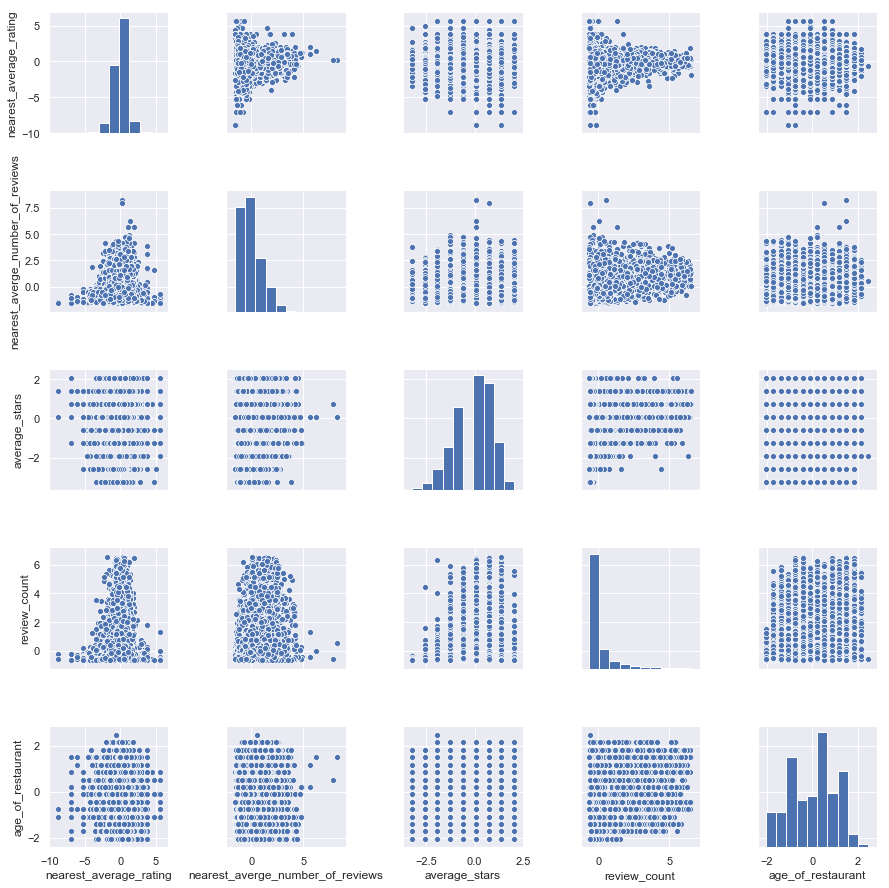

In [96]:
sns.pairplot(df)

## 2. Baseline Modeling

https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba

Eventhough, the data is unbalanced. I decided not to undersample or oversample it. It important to corretly guess a restaurant that is likely to be closed. Wrongly predicting that a well-doing restaurant is going to be closed is a lost business opportunity. 

I think there are many restaurants who ask for loan and a bank is more interested in finding restaurants that are likely to defalult in the next few years. I want to maximize positive recall with some precision loss.

For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

In [97]:
# these are the first 5 features
first_5 = ["nearest_average_rating", "nearest_averge_number_of_reviews", "average_stars", "review_count", "age_of_restaurant"] 
first_5

['nearest_average_rating',
 'nearest_averge_number_of_reviews',
 'average_stars',
 'review_count',
 'age_of_restaurant']

In [98]:
# these are the remaining
restaurants_vectorizer.get_feature_names()[:10]

['ability',
 'able',
 'absolute',
 'absolutely',
 'ac',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessible']

In [99]:
len(restaurants_vectorizer.get_feature_names())

3994

In [100]:
# combine the features
all_the_features =  first_5 + list(restaurants_vectorizer.get_feature_names())
len(all_the_features)

3999

In [101]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [102]:
y_train = y_train.flatten()
y_test = y_test.flatten()
y_test_resampled = y_test_resampled.flatten()
y_train_resampled = y_train_resampled.flatten()

### Logistic Regression

In [103]:
# unbalanced data
logistic_model = LogisticRegression()
logistic_model.fit(X_train_t, y_train)
y_pred = logistic_model.predict(X_test_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test.flatten(), y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_pred))
print("PR-AUC-Score", average_precision_score(y_test, y_pred))


 Confusion Matrix
Predicted     0     1
True                 
0          6575   444
1          1441  1038
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      7019
           1       0.70      0.42      0.52      2479

   micro avg       0.80      0.80      0.80      9498
   macro avg       0.76      0.68      0.70      9498
weighted avg       0.79      0.80      0.78      9498

ROC-AUC 0.6777301752443852
PR-AUC-Score 0.44498772919334273


In [104]:
# undersampled data(balanced)
logistic_model2 = LogisticRegression(penalty='l1', C=1.0)
logistic_model2.fit(X_train_rt, y_train_resampled)
y_pred = logistic_model2.predict(X_test_rt)
y_pred_train = logistic_model2.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))

print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1768   711
1           675  1804
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2479
           1       0.72      0.73      0.72      2479

   micro avg       0.72      0.72      0.72      4958
   macro avg       0.72      0.72      0.72      4958
weighted avg       0.72      0.72      0.72      4958

ROC-AUC 0.7204517950786608
PR-AUC-Score 0.6581292398894251
Accuracy:  0.7204517950786608
Train Accuracy:  0.7566068186403067


In [105]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(14):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(15):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

closed,groupon,mac,vegas,owner,hope,sliders,ayce,sign,yelp,concept,owners,decor,tapas,

Most negative cofficeints
(contribute negatively to restaurants closure)

rude,years,subway,fast,store,truck,busy,employees,drive,manager,favorite,bartenders,hotel,mcdonalds,customer,

In [106]:
#balanced logisic regression
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model2.coef_.ravel())[::-1]
for i in range(30):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model2.coef_.ravel())
for i in range(30):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

groupon,closed,concept,paradise,scottsdale,opening,owner,vegas,ayce,mac,gone,owners,spaghetti,dance,signs,flavors,chef,odd,yelp,sad,cheesesteak,heres,fan,sliders,hope,margaritas,idea,sign,brunch,tapas,

Most negative cofficeints
(contribute negatively to restaurants closure)

rude,bartenders,goto,busy,drive,years,subway,store,convenient,truck,attitude,airport,employees,beautiful,hotel,workers,fast,golf,manager,panda,wendys,mcdonalds,school,customer,tuesday,favorite,variety,usually,pool,parking,

In [107]:
# sfm = SelectFromModel(logistic_model)
# sfm.fit(X_train_t, y_train)
# logistic_model.fit(sfm.transform(X_train_t), y_train)
# y_pred = logistic_model.predict(sfm.transform(X_test_t))
# print("Number of features: ",  X_train_t.shape[1])
# print('\n Confusion Matrix')
# print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
# print(classification_report(y_test, y_pred))
# print("ROC-AUC", roc_auc_score(y_test, y_pred))
# print("PR-AUC-Score", average_precision_score(y_test, y_pred))

### K-Nearest-Neighbors

In [108]:
# imbalanced
nn_model = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
nn_model.fit(X_train_t, y_train)
y_pred = nn_model.predict(X_test_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_pred))
print("PR-AUC-Score", average_precision_score(y_test, y_pred))


 Confusion Matrix
Predicted     0    1
True                
0          6751  268
1          1922  557
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      7019
           1       0.68      0.22      0.34      2479

   micro avg       0.77      0.77      0.77      9498
   macro avg       0.73      0.59      0.60      9498
weighted avg       0.75      0.77      0.72      9498

ROC-AUC 0.5932526483610641
PR-AUC-Score 0.3540564121920134


In [109]:
# undersampled
nn_model2 = KNeighborsClassifier(n_neighbors=13, n_jobs=-1)
nn_model2.fit(X_train_rt, y_train_resampled)
y_pred = nn_model2.predict(X_test_rt)
y_pred_train = nn_model2.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))

print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1672   807
1           885  1594
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2479
           1       0.66      0.64      0.65      2479

   micro avg       0.66      0.66      0.66      4958
   macro avg       0.66      0.66      0.66      4958
weighted avg       0.66      0.66      0.66      4958

ROC-AUC 0.6587333602258976
PR-AUC-Score 0.60538149779262
Accuracy:  0.6587333602258976
Train Accuracy:  0.736887230179544


### Decision Trees

In [110]:
# unbalanced
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_t, y_train)
y_pred = dt_model.predict(X_test_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_pred))
print("PR-AUC-Score", average_precision_score(y_test, y_pred))


 Confusion Matrix
Predicted     0     1
True                 
0          5602  1417
1          1443  1036
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7019
           1       0.42      0.42      0.42      2479

   micro avg       0.70      0.70      0.70      9498
   macro avg       0.61      0.61      0.61      9498
weighted avg       0.70      0.70      0.70      9498

ROC-AUC 0.608014918993861
PR-AUC-Score 0.3284270165151558


In [ ]:
# sfm = SelectFromModel(dt_model)
# sfm.fit(X_train, y_train)
# dt_model.fit(sfm.transform(X_train), y_train)
# y_pred = dt_model.predict(sfm.transform(X_test))
# print("Number of features: ",  X_train.shape[1])
# print('\n Confusion Matrix')
# print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
# print(classification_report(y_test, y_pred))
# print("ROC-AUC", roc_auc_score(y_test, y_pred))
# print("PR-AUC-Score", average_precision_score(y_test, y_pred))

In [111]:
sorted_features = np.argsort(dt_model.feature_importances_)[::-1]
for i in range(20):
    print(all_the_features[sorted_features[i]], end=",")

nearest_averge_number_of_reviews,age_of_restaurant,review_count,average_stars,place,location,menu,order,nearest_average_rating,try,customer,fast,closed,good,restaurant,dishes,food,groupon,dinner,time,

In [112]:
# balanced
dt_model2 = DecisionTreeClassifier()
dt_model2.fit(X_train_rt, y_train_resampled)
y_pred = dt_model2.predict(X_test_rt)
y_pred_train = dt_model2.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print(classification_report(y_train_resampled, y_pred_train))

print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1516   963
1           977  1502
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      2479
           1       0.61      0.61      0.61      2479

   micro avg       0.61      0.61      0.61      4958
   macro avg       0.61      0.61      0.61      4958
weighted avg       0.61      0.61      0.61      4958

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       1.00      1.00      1.00      9914

   micro avg       1.00      1.00      1.00     19828
   macro avg       1.00      1.00      1.00     19828
weighted avg       1.00      1.00      1.00     19828

ROC-AUC 0.6087131908027431
PR-AUC-Score 0.5662422769110427
Accuracy:  0.608713190802743
Train Accuracy:  1.0


In [113]:
sorted_features = np.argsort(dt_model2.feature_importances_)[::-1]
for i in range(20):
    print(all_the_features[sorted_features[i]], end=",")

review_count,nearest_averge_number_of_reviews,age_of_restaurant,drive,customer,fast,order,nearest_average_rating,average_stars,restaurant,menu,service,staff,like,good,went,rude,little,place,employees,

### Naive Bayes

In [114]:
# unbalanced
model_nb = GaussianNB()
model_nb.fit(X_train_t.toarray(), y_train)
y_pred = model_nb.predict(X_test_t.toarray())
print('\n Confusion Matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_pred))
print("PR-AUC-Score", average_precision_score(y_test, y_pred))


 Confusion Matrix
Predicted     0     1
True                 
0          4781  2238
1          1074  1405
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      7019
           1       0.39      0.57      0.46      2479

   micro avg       0.65      0.65      0.65      9498
   macro avg       0.60      0.62      0.60      9498
weighted avg       0.70      0.65      0.67      9498

ROC-AUC 0.6239559758877261
PR-AUC-Score 0.33165972313180164


In [115]:
# balanced
model_nb2 = GaussianNB()
model_nb2.fit(X_train_rt.toarray(), y_train_resampled)
y_pred = model_nb2.predict(X_test_rt.toarray())
y_pred_train = model_nb2.predict(X_train_rt.toarray())
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1577   902
1          1026  1453
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      2479
           1       0.62      0.59      0.60      2479

   micro avg       0.61      0.61      0.61      4958
   macro avg       0.61      0.61      0.61      4958
weighted avg       0.61      0.61      0.61      4958

ROC-AUC 0.6111335215812828
PR-AUC-Score 0.5685677311497257
Accuracy:  0.6111335215812828
Train Accuracy:  0.6864030663707887


### Support Vector Machine

In [131]:
# # balanced data
# svc_model = SVC(kernel='linear', tol=0.001, C=5)
# svc_model.fit(X_train_rt, y_train_resampled)
# y_pred = svc_model.predict(X_test_rt)
# pickle.dump(svc_model, open("../../../../../yelp-dataset/svc_model.sav", 'wb'))

In [132]:
svc_model = pickle.load(open("../../../../../yelp-dataset/svc_model.sav", 'rb'))
svc_model.coef_

<1x3999 sparse matrix of type '<class 'numpy.float64'>'
	with 3999 stored elements in Compressed Sparse Row format>

In [133]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(svc_model.coef_.toarray()).ravel()[::-1]
for i in range(30):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(svc_model.coef_.toarray()).ravel()
for i in range(30):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

closed,groupon,paradise,mountain,unlimited,quiche,adds,concept,sliders,signs,balsamic,vegas,suggestion,ayce,dealing,scottsdale,ale,cheesesteak,buffets,henderson,mac,entering,margaritas,cooks,locally,opening,aspect,lean,odd,kalbi,

Most negative cofficeints
(contribute negatively to restaurants closure)

bartenders,appreciated,comped,tho,tuesday,convenient,goto,bus,everybody,watery,truck,rude,subway,wendys,uber,services,attitude,dated,cheers,program,occasionally,tzatziki,tourist,purchased,workers,products,years,rudely,brewery,understanding,

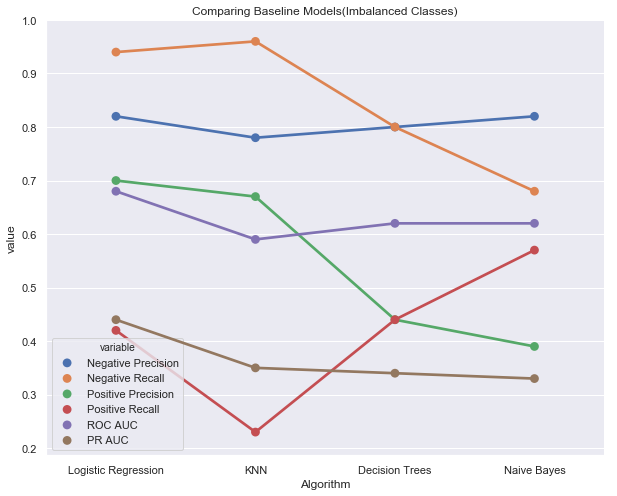

In [134]:
baseline_comparision = pd.DataFrame()
baseline_comparision["Negative Precision"] = pd.Series([0.82, 0.78, 0.8, 0.82])
baseline_comparision["Negative Recall"] = pd.Series([0.94, 0.96, 0.8, 0.68])
baseline_comparision["Positive Precision"] = pd.Series([0.7, 0.67, 0.44,0.39])
baseline_comparision["Positive Recall"] = pd.Series([0.42, 0.23, 0.44, 0.57])
baseline_comparision["ROC AUC"] = pd.Series([0.68, 0.59, 0.62, 0.62])
baseline_comparision["PR AUC"] = pd.Series([0.44, 0.35, 0.34, 0.33])
baseline_comparision["Algorithm"] = ["Logistic Regression", "KNN","Decision Trees","Naive Bayes"]
baseline_comparision_plot = pd.melt(baseline_comparision, id_vars="Algorithm")
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Comparing Baseline Models(Imbalanced Classes)")
sns.pointplot(x='Algorithm', y='value', hue='variable', data=baseline_comparision_plot, kind='bar', ax=ax)
sns.despine()

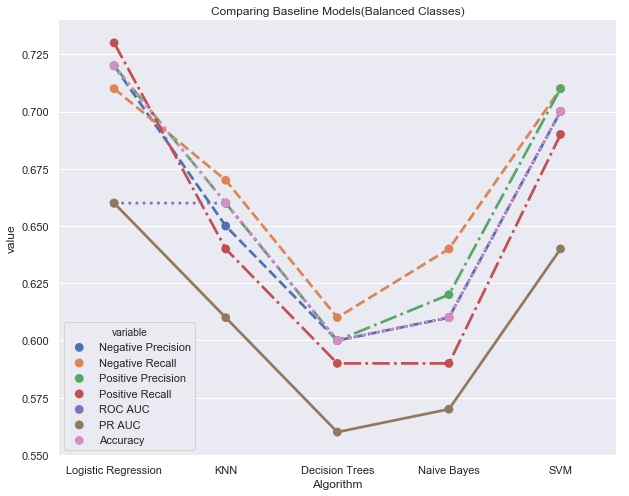

In [135]:
baseline_comparision2 = pd.DataFrame()
baseline_comparision2["Negative Precision"] = pd.Series([0.72, 0.65, 0.6, 0.61, 0.7])
baseline_comparision2["Negative Recall"] = pd.Series([0.71, 0.67, 0.61, 0.64, 0.71])
baseline_comparision2["Positive Precision"] = pd.Series([0.72, 0.66, 0.6,0.62, 0.71])
baseline_comparision2["Positive Recall"] = pd.Series([0.73, 0.64, 0.59, 0.59, 0.69])
baseline_comparision2["ROC AUC"] = pd.Series([0.66, 0.66, 0.6, 0.61, 0.7])
baseline_comparision2["PR AUC"] = pd.Series([0.66, 0.61, 0.56, 0.57, 0.64])
baseline_comparision2["Accuracy"] = pd.Series([0.72, 0.66, 0.6, 0.61, 0.7])

baseline_comparision2["Algorithm"] = ["Logistic Regression", "KNN","Decision Trees","Naive Bayes", "SVM"]
baseline_comparision_plot2 = pd.melt(baseline_comparision2, id_vars="Algorithm")
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Comparing Baseline Models(Balanced Classes)")
sns.pointplot(x='Algorithm', y='value', hue='variable', 
              data=baseline_comparision_plot2, 
              linestyles=["--", "--", "-.", "-.", ":", "-",":"],
               orient=True,
              ax=ax)
sns.despine()

## 3. Ensembles

### Random Forest

In [136]:
# balanced dataset
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(max_depth=50, n_estimators=900,  min_samples_leaf=15, n_jobs=-1)
rfc_model.fit(X_train_rt, y_train_resampled)
y_pred = rfc_model.predict(X_test_rt)
y_pred_train = rfc_model.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1695   784
1           734  1745
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2479
           1       0.69      0.70      0.70      2479

   micro avg       0.69      0.69      0.69      4958
   macro avg       0.69      0.69      0.69      4958
weighted avg       0.69      0.69      0.69      4958

ROC-AUC 0.6938281565147237
PR-AUC-Score 0.6337406615730299
Test Accuracy:  0.6938281565147236
Train Accuracy:  0.8811781319346379


### Gradient Boosing

In [137]:
# balanced dataset
from sklearn.ensemble import GradientBoostingClassifier
gbc_model2 = GradientBoostingClassifier(max_depth=3, subsample=0.8)
gbc_model2.fit(X_train_rt, y_train_resampled)
y_pred = gbc_model2.predict(X_test_rt)
y_pred_train = gbc_model2.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))

print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1754   725
1           701  1778
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2479
           1       0.71      0.72      0.71      2479

   micro avg       0.71      0.71      0.71      4958
   macro avg       0.71      0.71      0.71      4958
weighted avg       0.71      0.71      0.71      4958

ROC-AUC 0.7123840258168617
PR-AUC-Score 0.6508664793856891
Accuracy:  0.7123840258168617
Train Accuracy:  0.764978817833367


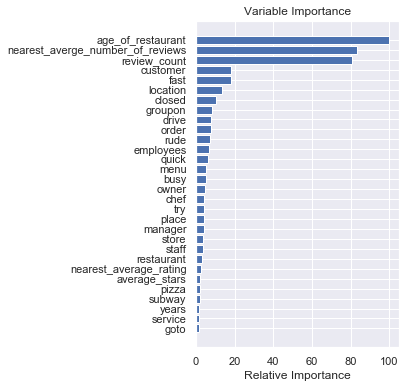

In [138]:
feature_importance = gbc_model2.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .7
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# print("\nColumn headers\n\n",X.columns)
# print("\n Feature Importance", feature_importance)
# print("\nargsorted from smallest to largest\n\n",sorted_idx)
# print("\nColumn headers\n\n",X.columns[sorted_idx])
# print("\nRearranged accordingly\n\n",feature_importance[sorted_idx])
# print("\nPosition on the y axis\n\n", pos)

### LightGBM

In [139]:
import lightgbm as lgb 
lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_error'
params['sub_feature'] = 0.5
params['num_leaves'] = 150
params['min_data'] = 50
params['max_depth'] = 30

#training our model using light gbm
num_round=1000
lgbm_model=lgb.train(params, lgb_train_data2, num_round)

y_pred = lgbm_model.predict(X_test_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_test_resampled)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model.predict(X_train_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_resampled)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))

C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0          1813   666
1           666  1813
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2479
           1       0.73      0.73      0.73      2479

   micro avg       0.73      0.73      0.73      4958
   macro avg       0.73      0.73      0.73      4958
weighted avg       0.73      0.73      0.73      4958

ROC-AUC 0.7313432835820896
PR-AUC-Score 0.669191356649588
Test Accuracy:  0.7313432835820896
Train Accuracy:  0.9044280815009078


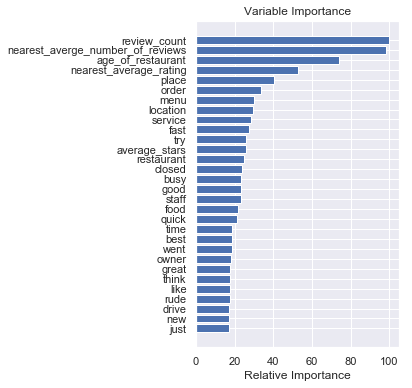

In [140]:
feature_importance = lgbm_model.feature_importance()
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# print("\nColumn headers\n\n",X.columns)
# print("\n Feature Importance", feature_importance)
# print("\nargsorted from smallest to largest\n\n",sorted_idx)
# print("\nColumn headers\n\n",X.columns[sorted_idx])
# print("\nRearranged accordingly\n\n",feature_importance[sorted_idx])
# print("\nPosition on the y axis\n\n", pos)

### XGBoost

In [141]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
# balanced dataset
xgboost_model.fit(X_train_rt, y_train_resampled)
y_pred = xgboost_model.predict(X_test_rt)
y_pred_train = xgboost_model.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1719   760
1           696  1783
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2479
           1       0.70      0.72      0.71      2479

   micro avg       0.71      0.71      0.71      4958
   macro avg       0.71      0.71      0.71      4958
weighted avg       0.71      0.71      0.71      4958

ROC-AUC 0.7063331988705122
PR-AUC-Score 0.6446685385710277
Accuracy:  0.7063331988705123
Train Accuracy:  0.7632640710106919


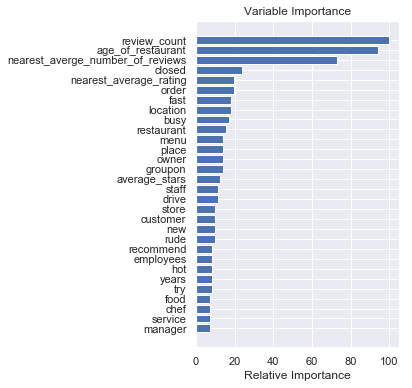

In [142]:
feature_importance = xgboost_model.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# print("\nColumn headers\n\n",X.columns)
# print("\n Feature Importance", feature_importance)
# print("\nargsorted from smallest to largest\n\n",sorted_idx)
# print("\nColumn headers\n\n",X.columns[sorted_idx])
# print("\nRearranged accordingly\n\n",feature_importance[sorted_idx])
# print("\nPosition on the y axis\n\n", pos)

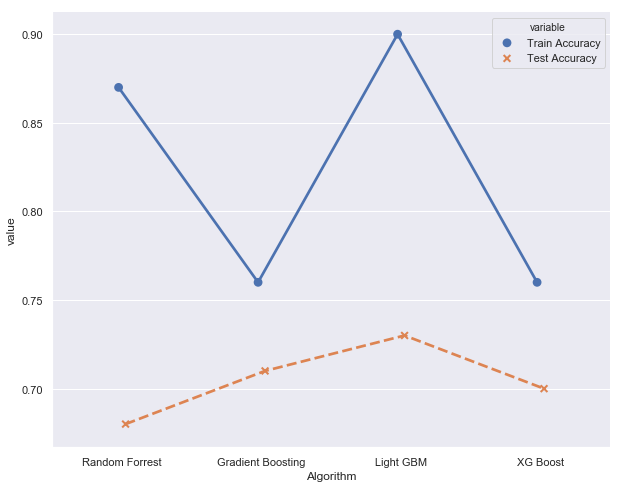

In [143]:
train_test_accuracy = pd.DataFrame()
train_test_accuracy["Train Accuracy"] = pd.Series([0.87, 0.76, 0.90, 0.76])
train_test_accuracy["Test Accuracy"] = pd.Series([0.68, 0.71, 0.73, 0.70])
train_test_accuracy["Algorithm"] = ["Random Forrest", "Gradient Boosting", "Light GBM", "XG Boost"]
train_test_accuracy_melted = train_test_accuracy.melt(id_vars="Algorithm")
fig, ax = plt.subplots(figsize=(10,8))
sns.pointplot(x="Algorithm", y="value", hue="variable", 
              data=train_test_accuracy_melted, dodge=True, 
              ax=ax, markers=["o", "x"],
             linestyles=["-", "--"])
sns.despine()

## 4. Parameter Tuning

### Best Parameters for Logistic Regression

In [144]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer()),("logistic", LogisticRegression())])

In [145]:
param_grid = {'logistic__C': [0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1.0, 1.25], 
                   'logistic__penalty' :['l2']
                  }
search = GridSearchCV(pipeline, param_grid, iid=False, cv=3,
                      return_train_score=True, n_jobs=-1)
search.fit(X_train_rt, y_train_resampled)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.714):
{'logistic__C': 1.25, 'logistic__penalty': 'l2'}


In [148]:
search.cv_results_

{'mean_fit_time': array([ 97.64327248, 114.16751663, 119.41345636, 110.62458038,
        106.71021891, 114.39975166, 114.52107199, 107.78578623]),
 'std_fit_time': array([ 0.84587821, 11.23787161,  7.03458923,  0.58366855,  0.68087731,
         5.3056871 ,  6.61873688,  0.49335848]),
 'mean_score_time': array([44.14026388, 46.24110516, 45.84710638, 42.15303612, 47.74272593,
        45.08403381, 41.3098472 , 38.10602713]),
 'std_score_time': array([0.12398267, 1.68975945, 2.41850621, 0.44898306, 0.65355524,
        1.78220884, 0.80009411, 0.13657846]),
 'param_logistic__C': masked_array(data=[0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1.0, 1.25],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_logistic__penalty': masked_array(data=['l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'p

### Best Parameters for LightGBM

In [149]:
# This code takes 4 hours, it results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [50, 100]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.8]
# gridParams['lgbm_classifier__bagging_freq'] = [5,10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.7, 0.8]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [30]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.7, 0.75, 0.80]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 74.3min

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 117.0min finished

{'lgbm_classifier__bagging_fraction': 0.8, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.7, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 30, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 50, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 150, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.7}

0.7127799072019366

In [150]:
# this code took 8 hours, it results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [100,150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [40, 50]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.7]
# gridParams['lgbm_classifier__bagging_freq'] = [10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.6, 0.7, 0.8]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [20,30]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.6, 0.7]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 57.8min
        
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 188.7min finished
        
{'lgbm_classifier__bagging_fraction': 0.7, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.6, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 50, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 100, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.6}

0.715856364736736

In [151]:
# This code took more than 8 hours. Its results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [100,150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [60, 70]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.6, 0.65]
# gridParams['lgbm_classifier__bagging_freq'] = [10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.5, 0.6, 0.7]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [20, 25]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.6, 0.65]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 51.4min
        
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 266.8min
        
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 396.1min finished
        
{'lgbm_classifier__bagging_fraction': 0.65, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.5, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 60, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 100, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.6}

0.7143937865644543

## 5. Testing Final Model

In [152]:
final_logistic_model = LogisticRegression(penalty='l2', C=1.25)
final_logistic_model.fit(X_train_rt, y_train_resampled)
y_pred = final_logistic_model.predict(X_test_rt)
y_pred_train = final_logistic_model.predict(X_train_rt)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))


 Confusion Matrix
Predicted     0     1
True                 
0          1781   698
1           677  1802
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2479
           1       0.72      0.73      0.72      2479

   micro avg       0.72      0.72      0.72      4958
   macro avg       0.72      0.72      0.72      4958
weighted avg       0.72      0.72      0.72      4958

ROC-AUC 0.7226704316256554
PR-AUC-Score 0.6605008471157725
Accuracy:  0.7226704316256555


In [153]:
import lightgbm as lgb 
lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

params = {}

params['bagging_fraction'] = 0.7
params['bagging_freq'] = 10
params['boosting_type'] = 'gbdt'
params['feature_fraction'] = 0.6
params['learning_rate'] = 0.01
params['max_bin'] = 300
params['max_depth'] = 20
    
params['metric'] = 'binary_error'
params['min_data_in_leaf'] = 50 
params['n_estimators'] = 100 
params['num_leaves'] = 100
params['objective'] = 'binary'
params['reg_alpha'] = 1.2, 
params['reg_lambda'] = 1.2
params['subsample'] = 0.6

num_round=100
lgbm_model_final=lgb.train(params, lgb_train_data2, num_round)

y_pred = lgbm_model_final.predict(X_test_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_test_resampled)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model_final.predict(X_train_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_resampled)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))

C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0          1746   733
1           704  1775
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2479
           1       0.71      0.72      0.71      2479

   micro avg       0.71      0.71      0.71      4958
   macro avg       0.71      0.71      0.71      4958
weighted avg       0.71      0.71      0.71      4958

ROC-AUC 0.7101653892698668
PR-AUC-Score 0.6487414537296705
Test Accuracy:  0.7101653892698668
Train Accuracy:  0.8016945733306435


In [154]:
import lightgbm as lgb 
lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

params = {}

params['bagging_fraction'] = 0.65
params['bagging_freq'] = 10
params['boosting_type'] = 'gbdt'
params['feature_fraction'] = 0.5
params['learning_rate'] = 0.01
params['max_bin'] = 300
params['max_depth'] = 20
    
params['metric'] = 'binary_error'
params['min_data_in_leaf'] = 60
params['n_estimators'] = 100 
params['num_leaves'] = 100
params['objective'] = 'binary'
params['reg_alpha'] = 1.2, 
params['reg_lambda'] = 1.2
params['subsample'] = 0.6

num_round=100
lgbm_model_final=lgb.train(params, lgb_train_data2, num_round)

y_pred = lgbm_model_final.predict(X_test_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_test_resampled)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model_final.predict(X_train_rt)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_resampled)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_resampled, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_resampled, y_pred_train))

C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
C:\Users\Tinsae\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0          1739   740
1           707  1772
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2479
           1       0.71      0.71      0.71      2479

   micro avg       0.71      0.71      0.71      4958
   macro avg       0.71      0.71      0.71      4958
weighted avg       0.71      0.71      0.71      4958

ROC-AUC 0.7081484469544171
PR-AUC-Score 0.6468308312114758
Test Accuracy:  0.7081484469544171
Train Accuracy:  0.7983155134153722


### Feature Importances for final lightgbm model

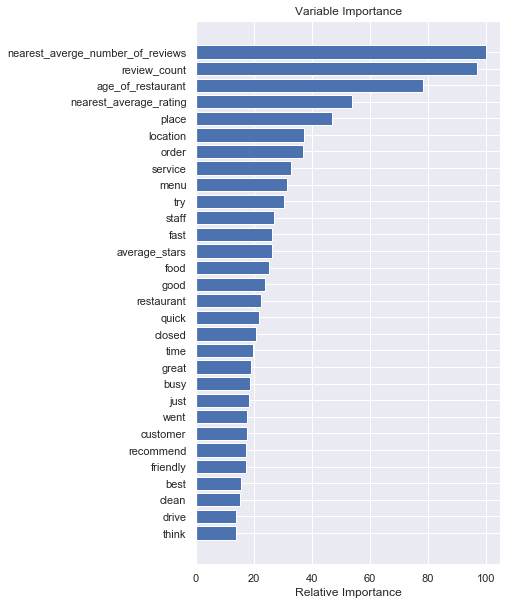

In [159]:
feature_importance = lgbm_model_final.feature_importance()
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
sns.set(rc={'figure.figsize':(12,10)})

plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Applying PCA

In [170]:
import numpy as np
from sklearn.decomposition import PCA

In [171]:
pca = PCA(n_components=5)

X_train_PCA = pca.fit_transform(X_train_rt.toarray())
X_test_PCA = pca.transform(X_test_rt.toarray())

In [172]:
pca.explained_variance_ratio_

array([0.24864031, 0.20874505, 0.16852665, 0.13603383, 0.10443565])

In [173]:
final_logistic_model155 = LogisticRegression(penalty='l2', C=1.25)
final_logistic_model155.fit(X_train_PCA, y_train_resampled)
y_pred = final_logistic_model155.predict(X_test_PCA)
y_pred_train = final_logistic_model155.predict(X_train_PCA)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_resampled, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_resampled, y_pred))
print("ROC-AUC", roc_auc_score(y_test_resampled, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_resampled, y_pred))
print("Accuracy: ", accuracy_score(y_test_resampled, y_pred))


 Confusion Matrix
Predicted     0     1
True                 
0          1565   914
1           884  1595
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      2479
           1       0.64      0.64      0.64      2479

   micro avg       0.64      0.64      0.64      4958
   macro avg       0.64      0.64      0.64      4958
weighted avg       0.64      0.64      0.64      4958

ROC-AUC 0.6373537716821298
PR-AUC-Score 0.5873173638234346
Accuracy:  0.6373537716821299


### Health Inspection Data

In [164]:
restaurant_inspection = pd.read_csv("../../../Data & Script/nevada_restaurant_inspection.csv").drop(["State", "Serial Number", "Employee ID", "Permit Number", "Inspection Time"], axis=1)

In [165]:
restaurant_inspection.head(3)

,Restaurant Name,Location Name,Category Name,Address,City,Zip,Current Demerits,Current Grade,Date Current,Inspection Date,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1
0,B & B RISTORANTE GARDE MANGER,B & B RISTORANTE @ VENETIAN,Garde Manger,3355 S Las Vegas Blvd,Las Vegas,89109-8941,0,A,1/26/2018 0:00,1/26/2018 0:00,Routine Inspection,0,A,A,'A' Grade,2928,1/26/2018 12:04,"(36.1214517, 115.1696112)"
1,7-Eleven #32224 - SNACK BAR,7-Eleven Convenience Store #32224,Snack Bar,5576 Boulder Hwy,Las Vegas,89122-6010,3,A,2/9/2017 0:00,2/9/2017 0:00,Routine Inspection,3,A,A,'A' Grade,"2,152,927",2/9/2017 10:37,"(36.101164, 115.0522322)"
2,BIGG MAXX'S DOGGS MOBILE,BIGG MAXX'S DOGGS MOBILE,Food Trucks / Mobile Vendor,2025 E SAHARA Ave,Las Vegas,89104,0,A,10/29/2018 0:00,10/29/2018 0:00,Routine Inspection,0,A,NaN,'A' Grade,NaN,10/29/2018 15:25,"(36.1435717, 115.1247266)"


In [166]:
restaurant_inspection.columns

Index(['Restaurant Name', 'Location Name', 'Category Name', 'Address', 'City',
       'Zip', 'Current Demerits', 'Current Grade', 'Date Current',
       'Inspection Date', 'Inspection Type', 'Inspection Demerits',
       'Inspection Grade', 'Permit Status', 'Inspection Result', 'Violations',
       'Record Updated', 'Location 1'],
      dtype='object')